# Duck or Cat

DOC - Duck or Cat is a binary classification model. It classifies pictures of ducks and cats.


[GitHub link](https://github.com/GregoryHue/DuckOrCat)

# GPU Installation check

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf 
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

print(tf.test.is_built_with_cuda())

2.12.0
1:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2:  <function is_built_with_cuda at 0x7f1760378280>
3:  /device:GPU:0
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


# Imports

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical, load_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# Checking directory

In [3]:
!ls

/bin/bash: /home/ghue/.conda/envs/env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
DuckOrCat.ipynb  dataset


# Setting global variables

In [4]:
TRAIN_PATH = "dataset/train/"
TEST_PATH = "dataset/test/"
CATEGORIES =  os.listdir(TRAIN_PATH)
EPOCHS = 50

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE=15

# Model structure

In [5]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#model.summary()

# Data exploration

In [6]:

filenames = []
categories = []

index = 0
for category in CATEGORIES:
  folder = os.listdir(TRAIN_PATH + category)
  for f in folder:
    if category.casefold() in f.casefold():
      filenames.append(category + '/' + f)
      categories.append(category)
  index = index + 1

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

## Structure

In [7]:
df.head()

,filename,category
0,Duck/duck_8487.jpeg,Duck
1,Duck/duck_6648.jpeg,Duck
2,Duck/duck_6073.jpeg,Duck
3,Duck/duck_4097.jpeg,Duck
4,Duck/duck_8456.jpeg,Duck


In [8]:
df.tail()

,filename,category
18119,Cat/cat_9764.jpeg,Cat
18120,Cat/cat_6128.jpeg,Cat
18121,Cat/cat_10386.jpeg,Cat
18122,Cat/cat_10567.jpeg,Cat
18123,Cat/cat_2668.jpeg,Cat


## Category repartition

<Axes: xlabel='category'>

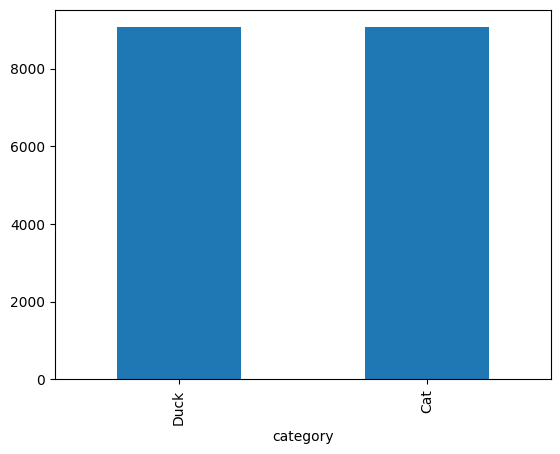

In [9]:
df['category'].value_counts().plot.bar()

## Data sample

dataset/train/duck_4406.jpeg


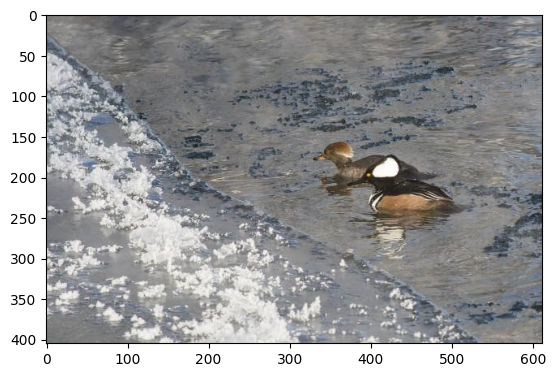

In [10]:
random_category = random.choice(CATEGORIES)
random_file = random.choice(os.listdir(TRAIN_PATH + random_category + '/'))
print(TRAIN_PATH + random_file)
image = load_img(TRAIN_PATH + random_category + '/' + random_file)
plt.imshow(image)

## Callbacks

### Early stop

In [11]:
earlystop = EarlyStopping(patience=10)

### Learning rate reduction

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### Checkpoints

In [13]:
checkpoint_path = 'checkpoints/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoints = ModelCheckpoint(checkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch")

In [14]:
callbacks = [earlystop, learning_rate_reduction, checkpoints]

# Train and validate dataset

# Spliting datasets

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

test_filenames = []

for category in CATEGORIES:
  folder = os.listdir(TEST_PATH + category)
  for f in folder:
    if category.casefold() in f.casefold():
      test_filenames.append(category + '/' + f)

test_df = pd.DataFrame({
    'filename': test_filenames
})

TOTAL_TRAIN = train_df.shape[0]
TOTAL_VALIDATE = validate_df.shape[0]
TOTAL_TEST = test_df.shape[0]

## Generators

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14499 validated image filenames belonging to 2 classes.
Found 3625 validated image filenames belonging to 2 classes.
Found 4002 validated image filenames.


## Model fitting

In [17]:


history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=TOTAL_VALIDATE//BATCH_SIZE,
    steps_per_epoch=TOTAL_TRAIN//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/50


2023-06-22 20:45:35.691519: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


966/966 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8824
Epoch 1: saving model to checkpoints/cp-0001.ckpt
966/966 [==============================] - 99s 92ms/step - loss: 0.3413 - accuracy: 0.8824 - val_loss: 0.3951 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 2/50
966/966 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9244
Epoch 2: saving model to checkpoints/cp-0002.ckpt
966/966 [==============================] - 80s 83ms/step - loss: 0.1988 - accuracy: 0.9244 - val_loss: 0.6675 - val_accuracy: 0.7748 - lr: 0.0010
Epoch 3/50
966/966 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9348
Epoch 3: saving model to checkpoints/cp-0003.ckpt
966/966 [==============================] - 78s 81ms/step - loss: 0.1790 - accuracy: 0.9348 - val_loss: 0.4109 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 4/50
966/966 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9431
Epoch 4: saving model to checkpoints/cp

In [18]:
model.save('model.h5')

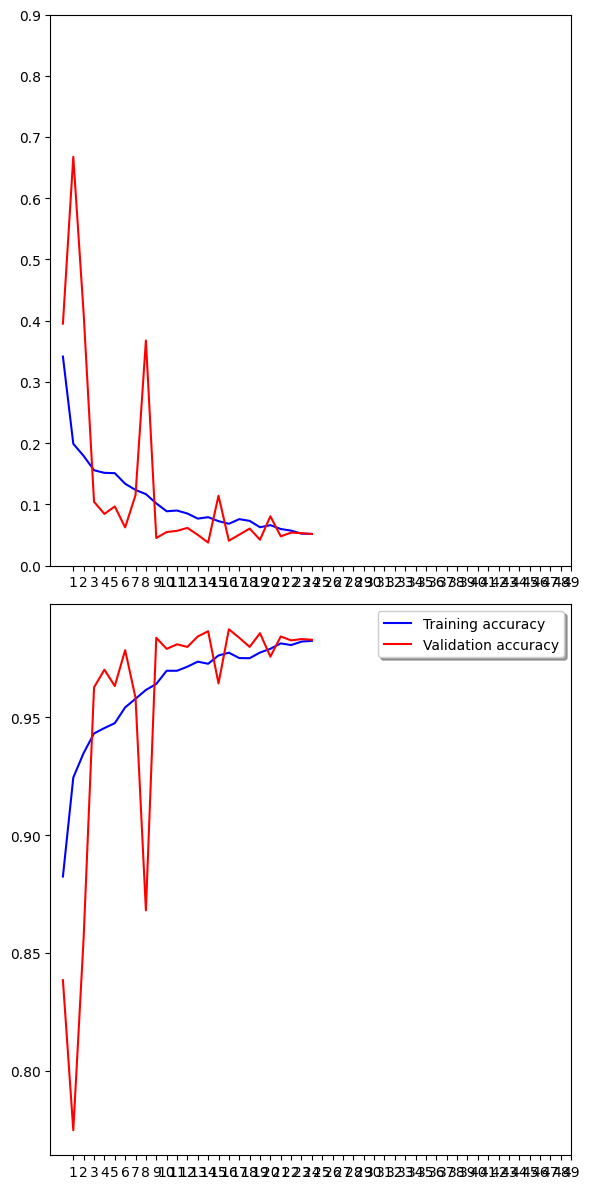

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [20]:
predict = model.predict(test_generator, steps=np.ceil(TOTAL_TEST/BATCH_SIZE))

267/267 [==============================] - 11s 38ms/step


<Axes: xlabel='category'>

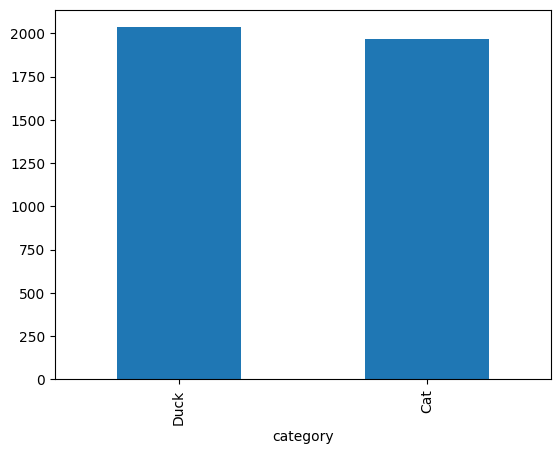

In [21]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'].value_counts().plot.bar()

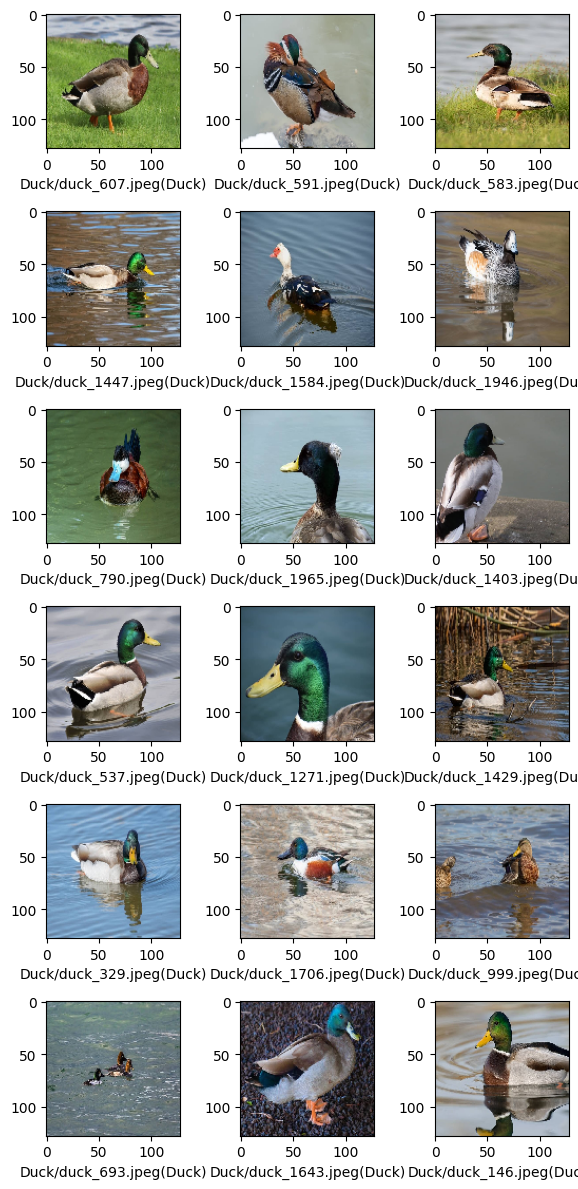

In [22]:
sample_cat = test_df.head(18)
plt.figure(figsize=(6, 12))
index = 0
for __, row in sample_cat.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(TEST_PATH + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    index = index + 1
plt.tight_layout()
plt.show()

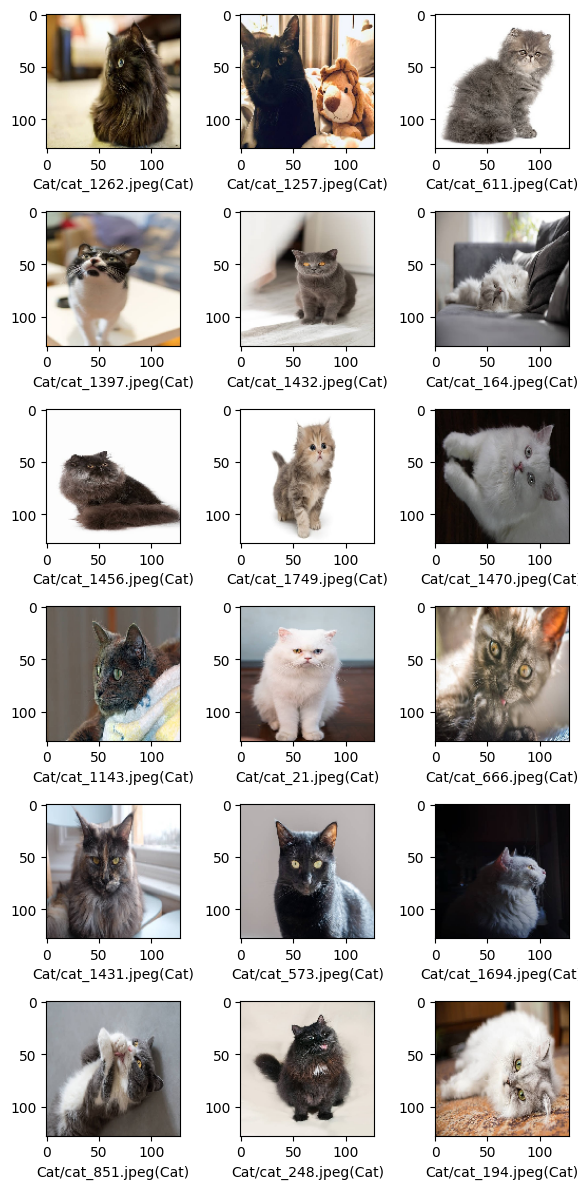

In [23]:
sample_duck = test_df.tail(18)
plt.figure(figsize=(6, 12))
index = 0
for __, row in sample_duck.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(TEST_PATH + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    index = index + 1
plt.tight_layout()
plt.show()

In [24]:
results = model.evaluate(validation_generator, batch_size=BATCH_SIZE)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

242/242 [==============================] - 9s 36ms/step - loss: 0.0514 - accuracy: 0.9829
    Test Loss: 0.05145
Test Accuracy: 98.29%


242/242 [==============================] - 7s 26ms/step


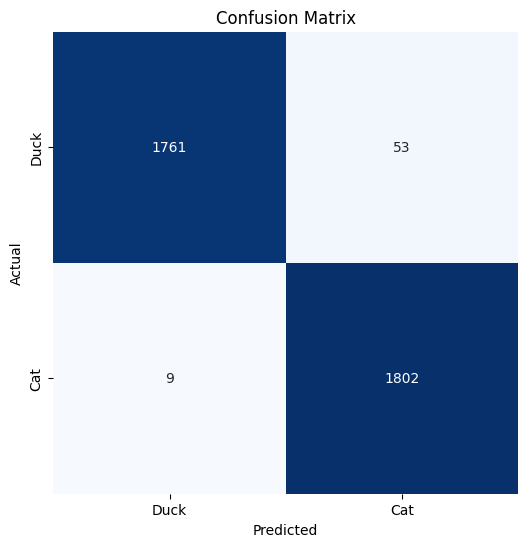

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1814
           1       0.97      1.00      0.98      1811

    accuracy                           0.98      3625
   macro avg       0.98      0.98      0.98      3625
weighted avg       0.98      0.98      0.98      3625



In [25]:
new_predictions = []

predictions = model.predict(validation_generator, batch_size=BATCH_SIZE)

for prediction in predictions:
    
    if round(prediction[0], 4) <= 0.5:
        new_predictions.append(1)
    elif round(prediction[0], 4) >= 0.5:
        new_predictions.append(0)
    
        
cm = confusion_matrix(validation_generator.labels, new_predictions)
clr = classification_report(validation_generator.labels, new_predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=CATEGORIES)
plt.yticks(ticks=[0.5, 1.5], labels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)